# Simple eCommerce Implementation
### Lifetime Value (Non-Contractual Setting)
Sources:
- https://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf

In [37]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### **The BG/NBD Model**
To predict future transactions the model treats the customer purchasing behaviour as a coin tossing game. Each customer has 2 coins: 
- a buy coin that controls the probability of a customer to purchase
- a die coin that controls the probability of a customer to quit and never purchase again.

### **BG/NBD Assumptions**
#### **<font color=purple>- Transaction Rate, λ-</font>**
***Assumption #1:*** <font color=green>While active, the number of transactions made by a customer follows a **Poisson Process with transaction rate λ** (=expected number of transactions in a time interval).</font>
- At every sub-period (1 month) of a specific time interval (12 months) **each customer tosses his buy coin and, depending on the result, he purchases or not.**

- The number of transactions (heads) we observe in the period depends on each customer’s probability distribution around λ. 

***Assumption #2:*** <font color=green>Heterogeneity in transaction rates among customers follows **a Gamma distribution.**</font>
- This is equivalent to saying that **each customer has its own buy coin (with its very own probability of head and tail).**

<font color=blue>**Parameters:** shape parameter ***r*** and scale parameter ***α***</font>

#### <font color=purple>- **Dropout Rate**, ***μ*** -</font>
***Assumption #3:*** <font color=green>After any transaction, a customer becomes inactive with probablity ***μ***, **according to a (shifted) Geometric distribution**.</font>
- Customers start with a high prob of inactivity
- The more the customer purchases the higher his probability of being alive.

***Assumption #4:*** <font color=green>Heterogeneity in ***μ*** follows a **Beta distribution**.</font>
- In addition to the buy coin, **each customer has his own die coin with its own probability of being alive** after a specific amount of transactions.

<font color=blue>**Parameters:** shape parameter ***s*** and scale parameter ***β***</font>

#### **<font color=purple>- Overall -</font>**
***Assumption #5:*** <font color=green> The transaction rate **λ** and the dropout probability **p**, **vary independently across customers**.</font>

### **BG/NBD Model Outputs**
By fitting the above distributions on our historical customer data, we are able to derive the following information for each customer:

- **P(X(t) = x | λ, p)** - the probability of observing x transactions in a time period of length t
- **E(X(t) | λ, p)** - the expected number of transactions in a time period of length t
- **P(τ>t)** - the probability of a customer becoming inactive at period τ

## Import Data

In [38]:
# Read in data
df = pd.read_excel("Online_Retail.xlsx")

In [39]:
# Quick check data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Clean Data

In [40]:
# Check for data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### - <font color=blue>Missing Data: Explore</font> -

In [41]:
# How much data is missing?

# Table of Columns and their respective percentages of missing data
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
CustomerID,135080,0.249267
Description,1454,0.002683
Country,0,0.000000
UnitPrice,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
StockCode,0,0.000000
InvoiceNo,0,0.000000


In [42]:
# Visualize missing data
import missingno as msno

# Convert Train Set into Boolen Values based on whether are
missingdata_df = df.columns[df.isnull().any()].tolist()

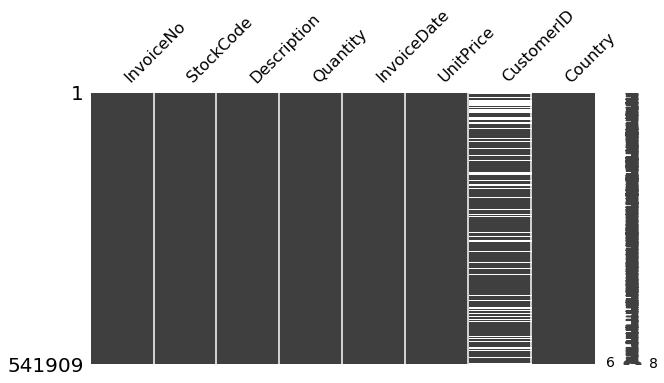

In [43]:
# Nullity matrix for missing Train Set value
msno.matrix(df, figsize=(10,5))

With only two features missing data, I do not see any noticable pattern and thus assume that this data is missing at random.

#### - <font color=blue>Missing Data: Handle</font> -

In [44]:
# Filter df to include observations with Customer ID
df2 = df[pd.notnull(df['CustomerID'])]

#### - <font color=blue>Feature Type: Handle</font> -

In [45]:
# Convert invoice date-seconds to data
import datetime as dt
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate']).dt.date

## Feature Creation

In [46]:
# Calculate Sale per Transaction
df2['Sales'] = df2['Quantity'] * df2['UnitPrice']

#### - <font color=blue>Data Pre-Processing</font> -

In [47]:
# Return observations with only positive sales
df2 = df2[df2['Sales'] > 0]

## Understanding the RFM DataFrame

In [48]:
# Create list of features need for RFM
rfm_features = ['CustomerID', 'InvoiceDate', 'Sales']

In [49]:
# Transform dataframe to RFM format
from lifetimes.utils import summary_data_from_transaction_data
rfm_data = summary_data_from_transaction_data(df2[rfm_features], 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')

print(f'# of Customers in Analysis: {rfm_data.shape[0]}\n')
rfm_data.head()

# of Customers in Analysis: 4338



,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


There are 4339 customers under our analysis.

CustomerID 12346 made 1 purchase only (no repeat), so his frequency and recency are 0, and his age is 325 days (e.g. the duration between his first purchase and the end of the period in the analysis).

#### - <font color=blue>Distribution of RFM</font> -

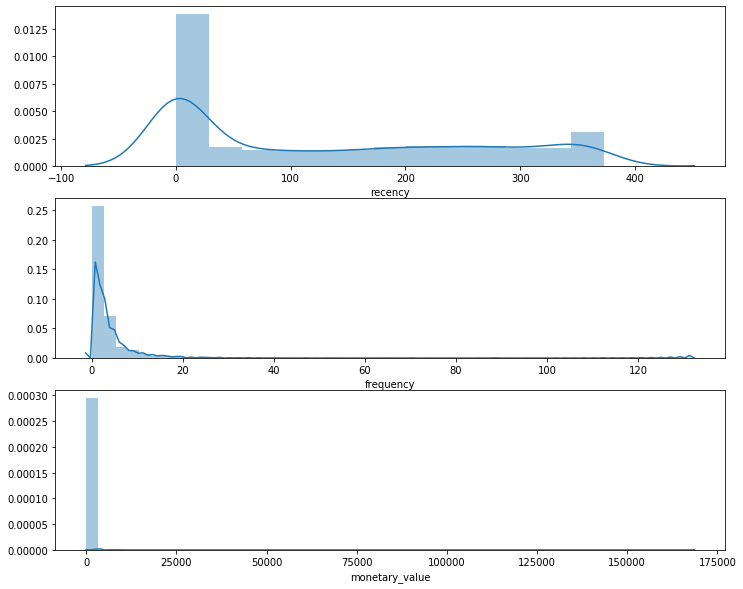

In [50]:
# Plot RFM distributions
plt.figure(figsize=(12,10))# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_data['recency'])# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_data['frequency'])# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_data['monetary_value'])# Show the plot
plt.show()

#### - <font color=blue>Distribution of Frequency</font> -

- Here we notice a highly, right-skewed distribution with a long tail. This long tail could illustrate our "power customers".
- We also notice a large concentration around **Frequency = 0**. Let's see what percentage of users have only purchased once.

## Training Model and Visualizing Our Model Frequency/Recency Matrix

#### - <font color=blue>Fit Model</font> -

We first need to fit the customer probability model to the data so that it picks up on their behaviors and pattern. This is done by looking at each individual’s Frequency, Recency and Age and adjusting its parameters so that it better reflects the intervals in which our customer-base purchases.

In [72]:
# Fit Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_data['frequency'], rfm_data['recency'], rfm_data['T'])

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,5.936227e-01,1.480185e-02,5.646111e-01,6.226344e-01
alpha,4.942295e+01,1.638651e+00,4.621119e+01,5.263470e+01
a,8.067543e-18,6.652126e-12,-1.303816e-11,1.303818e-11
b,3.555386e-08,2.931567e-02,-5.745868e-02,5.745875e-02


Here, we fitted the distributions mentioned above to our customer data and derived the model parameters: 
- **Assumption 2, Gamma distribution** - ***r*** and ***alpha*** 
- **Assumption 4, Beta distribution** - ***a*** and ***b*** 

#### <font color=purple>*Which Customers Are Most Likely Alive/Dead?*</font>

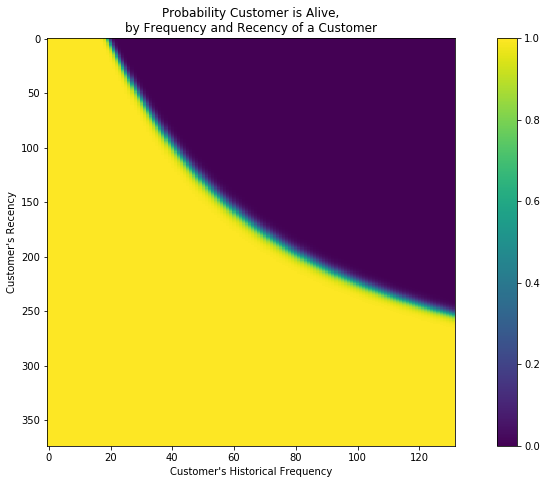

In [73]:
# Frequency Recency Matrix
from lifetimes.plotting import plot_probability_alive_matrix
plt.figure(figsize=(15,7.5))
plot_probability_alive_matrix(bgf)
plt.show()

#### <font color=purple>*How Many Future Purchases Can We Expect for 1 Unit of Time?*</font>

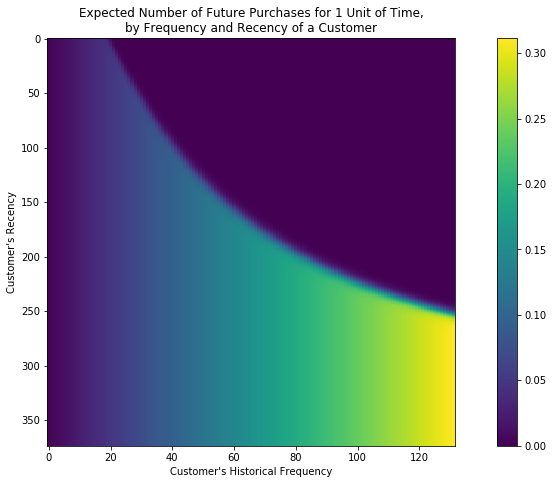

In [74]:
# Frequency Recency Matrix
from lifetimes.plotting import plot_frequency_recency_matrix
plt.figure(figsize=(15,7.5))
plot_frequency_recency_matrix(bgf)
plt.show()

## Evaluating Model Performance
#### Frequency/Recency analysis using the BG/NBD model

### <font color=blue>1) Calibration Period Histogram</font>
#### <font color=green>*Does the model fit the training data?*</font>

So we've built a model... Does it suck?

In order to assess our fitted model, we will: 
- Artificially generate customers based on the fitted model parameters.
- Compare it to the real data

<Figure size 1080x540 with 0 Axes>

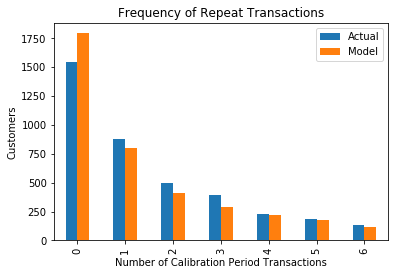

In [75]:
# Acutal vs Artifical Freq Transactions
from lifetimes.plotting import plot_period_transactions
plt.figure(figsize=(15,7.5))
plot_period_transactions(bgf)
plt.show()

The distribution of the artificial customers seems to closely resemble the actual data. This it does not suck!

### <font color=blue>2) Cumulative Transaction Plot</font>
#### <font color=green>*Does the model predict cumulative sales well?*</font>

In [76]:
import datetime
df2.InvoiceDate.min() - datetime.date(2011, 6, 8)

datetime.timedelta(days=-189)

In [77]:
# Split dataset: Calibration and Hold-out Set
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df2, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-01',
                                        observation_period_end='2011-12-9' )   

# Fit model to Calibration set
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2725 subjects, a: 0.00, alpha: 40.76, b: 0.00, r: 0.50>

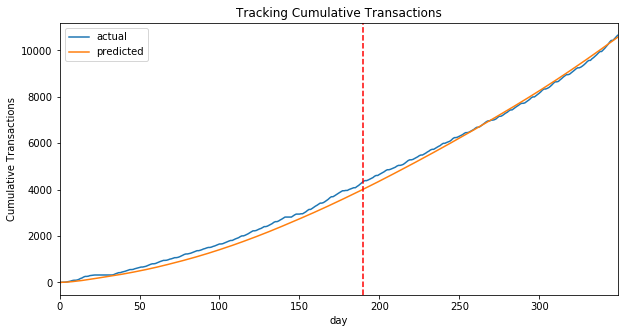

In [78]:
# Cumulative Transaction Plot
from lifetimes.plotting import plot_cumulative_transactions

plt.figure(figsize=(10,5))
plot_cumulative_transactions(bgf, df2, 'InvoiceDate', 'CustomerID', 350, 190)

Beautiful

### <font color=blue>3) Incremental Transactions Plot</font>
#### <font color=green>*Does the model capture the overall trend in transactions?*</font>.ipynb_checkpoints/

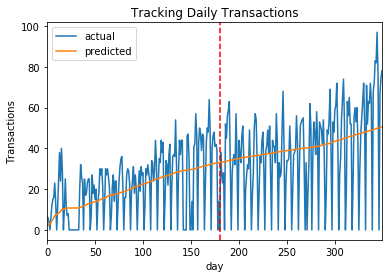

In [79]:
# Incremental Transactions Plot
from lifetimes.plotting import plot_incremental_transactions

plot_incremental_transactions(bgf, df2, 'InvoiceDate', 'CustomerID', 350, 180)

This plot shows that the model does a decent job capturing general trends in the data.

### <font color=blue>4) Conditional Expectations Plot</font>
#### <font color=green>*Can the model predict the number of purchases a customer will make based on the training data?*</font>

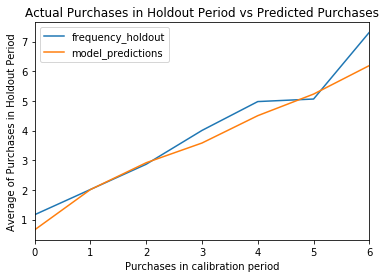

In [80]:
# Conditional Expectations Plot
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## Estimating customer lifetime value using the Gamma-Gamma model

In [81]:
# Filter out Monetary Values less than zero, avoiding error
returning_customers_summary = rfm_data[rfm_data['monetary_value']>0]

In [82]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>

#### <font color=purple>*What does the distribution of LTV look like?*</font>

In [83]:
# Calculate Expected LTV for Each Customer
ltvs = ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],returning_customers_summary['monetary_value'])

# Reset Index and Name columns
ltvs = ltvs.reset_index()
ltvs. columns = ['CustomerID','LTV']
ltvs.head()

,CustomerID,LTV
0,12347.0,569.978836
1,12348.0,333.784235
2,12352.0,376.175359
3,12356.0,324.039419
4,12358.0,539.907126


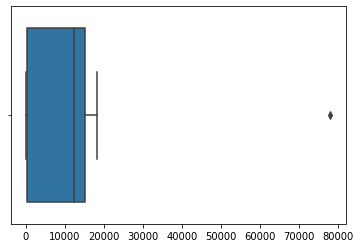

In [84]:
# LTV Boxplot
sns.boxplot(ltvs)

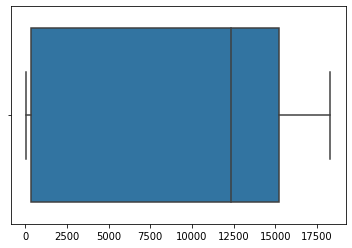

In [85]:
# LTV Boxplot Removing all values over 20,000
sns.boxplot(ltvs[ltvs < 20000])

By removing the ~$80,000 outlier we can get a more granular look at the distribution of LTV over the population

#### <font color=purple>*What is the Present Value of Existing Customers?*</font>

In [86]:
print(f"${round(sum(ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],returning_customers_summary['monetary_value'])),2):,}")

$1,268,317.23


## Segment Customers On RFM Score

#### <font color=purple>*What is each customer's RFM Score?*</font>

In [87]:
# Quantile Binning function to solve "unique binning end" error
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

# Empty DF for RFM Scores
rfm_scores = pd.DataFrame(columns=['recency', 'frequency', 'monetary'])

# Cast all values to floats (double check)
rfm_scores['recency'] = rfm_data['recency'].astype(float)
rfm_scores['frequency'] = rfm_data['frequency'].astype(float)
rfm_scores['monetary'] = rfm_data['monetary_value'].astype(float)

# Assign each score a value 1-5 based on Quantile
rfm_scores['recency'] = pct_rank_qcut(rfm_data.recency, 5)
rfm_scores['frequency'] = pct_rank_qcut(rfm_data.frequency, 5)
rfm_scores['monetary'] = pct_rank_qcut(rfm_data.monetary_value, 5)

***For the sake of simplicity we will just be adding the scores up and then creating segments based on these totals.*** 

With more domain knowledge we can get creative with this calculation

In [88]:
# Calculate RFM_Scores
rfm_scores['RFM_Score'] = rfm_scores[rfm_scores.columns].sum(axis=1)

# Add LTV
rfm_scores = pd.merge(rfm_scores,ltvs,on='CustomerID')
rfm_scores.head()

,CustomerID,recency,frequency,monetary,RFM_Score,LTV
0,12347.0,5,5,5,15,569.978836
1,12348.0,5,4,4,13,333.784235
2,12352.0,4,5,4,13,376.175359
3,12356.0,5,4,4,13,324.039419
4,12358.0,3,3,5,11,539.907126


## LTV Scenarios

#### <font color=purple>*How many of our stars are at risk?*</font>

In [89]:
rfm_scores[(rfm_scores['recency'] < 3) &
           (rfm_scores['frequency'] > 3) &
           (rfm_scores['monetary'] > 3)].sort_values('LTV', ascending=False).head()

,CustomerID,recency,frequency,monetary,RFM_Score,LTV
2290,17203.0,2,4,5,11,880.081967
2440,17509.0,2,4,5,11,720.984302
2409,17444.0,2,4,5,11,712.233298
303,12950.0,2,4,5,11,637.303226
520,13447.0,2,4,5,11,439.546345


#### <font color=purple>*Who are our Recent, Frequent but "Cheap" customers?*</font>

In [90]:
rfm_scores[(rfm_scores['recency'] > 3) &
           (rfm_scores['frequency'] == 5) &
           (rfm_scores['monetary'] < 3)].sort_values('LTV', ascending=False).tail()

,CustomerID,recency,frequency,monetary,RFM_Score,LTV
959,14344.0,4,5,2,11,128.961824
2032,16668.0,4,5,2,11,120.325438
1073,14560.0,5,5,2,12,114.825106
2677,18037.0,4,5,2,11,85.089814
2653,17961.0,5,5,2,12,47.057076


## LTV/RFM Customer Grades

#### <font color=purple>*Consumer Personas and Strategies*</font>

This is merely a template on assigning personas/grades to each of our customers

In [35]:
# Create Categories at Different Thresholds of RFM_Score
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Stars'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

rfm_scores['RFM_Level'] = rfm_scores.apply(rfm_level, axis=1)
rfm_scores.head()

,CustomerID,recency,frequency,monetary,RFM_Score,LTV,RFM_Level
0,12347.0,5,5,5,15,569.978836,Stars
1,12348.0,5,4,4,13,333.784235,Stars
2,12352.0,4,5,4,13,376.175359,Stars
3,12356.0,5,4,4,13,324.039419,Stars
4,12358.0,3,3,5,11,539.907126,Stars


In [36]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_scores.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)# Print the aggregated dataset
print(rfm_level_agg)

          recency frequency monetary      
             mean      mean     mean count
RFM_Level                                 
Champions     2.5       3.0      2.5    99
Loyal         2.0       3.0      2.0    44
Stars         3.9       4.0      3.9  2647
